In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
data = pd.read_csv("C://Users/sampa/ai_class/data_files/diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
X = data.drop(columns=["Outcome"])
y = data["Outcome"]

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [7]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32).view(-1, 1)

In [8]:
batch_size = 4
train_set = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

test_set = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

In [9]:
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = Model(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = 0.0

    for features, targets in train_loader:
        outputs = model(features)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()

    avg_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss_epoch = 0.0
    with torch.no_grad():
        for features, targets in test_loader:
            outputs = model(features)
            loss = criterion(outputs, targets)

            val_loss_epoch += loss.item()

        avg_val_loss = val_loss_epoch / len(test_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/50 - Train Loss: 0.1990, Val Loss: 0.1693
Epoch 2/50 - Train Loss: 0.1631, Val Loss: 0.1620
Epoch 3/50 - Train Loss: 0.1594, Val Loss: 0.1724
Epoch 4/50 - Train Loss: 0.1541, Val Loss: 0.1683
Epoch 5/50 - Train Loss: 0.1510, Val Loss: 0.1746
Epoch 6/50 - Train Loss: 0.1455, Val Loss: 0.1709
Epoch 7/50 - Train Loss: 0.1463, Val Loss: 0.1749
Epoch 8/50 - Train Loss: 0.1446, Val Loss: 0.1745
Epoch 9/50 - Train Loss: 0.1423, Val Loss: 0.1744
Epoch 10/50 - Train Loss: 0.1420, Val Loss: 0.1688
Epoch 11/50 - Train Loss: 0.1397, Val Loss: 0.1774
Epoch 12/50 - Train Loss: 0.1389, Val Loss: 0.1717
Epoch 13/50 - Train Loss: 0.1377, Val Loss: 0.1678
Epoch 14/50 - Train Loss: 0.1379, Val Loss: 0.1738
Epoch 15/50 - Train Loss: 0.1356, Val Loss: 0.1740
Epoch 16/50 - Train Loss: 0.1365, Val Loss: 0.1747
Epoch 17/50 - Train Loss: 0.1363, Val Loss: 0.1777
Epoch 18/50 - Train Loss: 0.1338, Val Loss: 0.1760
Epoch 19/50 - Train Loss: 0.1328, Val Loss: 0.1709
Epoch 20/50 - Train Loss: 0.1333, Val Lo

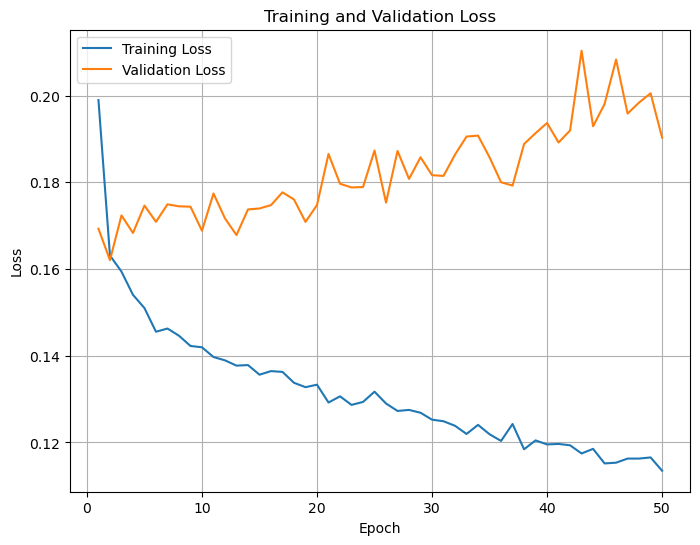

In [12]:
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
all_preds = []
all_labels = []
model.eval()

with torch.no_grad():
    for features, targets in test_loader:
        outputs = model(features)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())


mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_labels, all_preds)
r2 = r2_score(all_labels, all_preds)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² score: {r2:.4f}")

RMSE: 0.5976
MAE: 0.3571
R² score: -0.5556
